In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from google.colab import filesuploaded = files.upload()


In [ ]:
%%time
#Train
wheat_train = pd.read_csv('train.csv')

def data_clean(data_frame):
    seperator = lambda x: np.fromstring(x[1:-1],sep = ',')
    bbox = np.stack(data_frame['bbox'].apply(seperator))
    for i,dim in enumerate(['x','y','w','h']):
        data_frame[dim] = bbox[:,i]
    data_frame.drop(columns ='bbox', inplace = True)

#Cleaning the Train Data by seperating the bbox into seperate columns for each dimension
data_clean(wheat_train)
wheat_train.head()

CPU times: user 880 ms, sys: 45.4 ms, total: 925 ms
Wall time: 944 ms


,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
image_ids = wheat_train['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [ ]:
valid_df = wheat_train[wheat_train['image_id'].isin(valid_ids)]
train_df = wheat_train[wheat_train['image_id'].isin(train_ids)]

In [ ]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [ ]:
class LoadDatasett):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)  #reading an image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].to_numpy()
        area = (boxes[:, 3]) * (boxes[:, 2])  #Calculating area of boxes
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  #upper coordinate
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  #lower coordinate
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] =  torch.tensor(sample['bboxes']).float()
            return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_train_transform():
    return A.Compose(
        [
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

DIR_INPUT = 'Dataset/'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_dataset = LoadDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = LoadDataset(valid_df, DIR_TRAIN, get_valid_transform())


indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size= 16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[10]['boxes'].cpu().numpy().astype(np.int32)
print(boxes.shape)
sample = images[10].permute(1,2,0).cpu().numpy()

(28, 4)


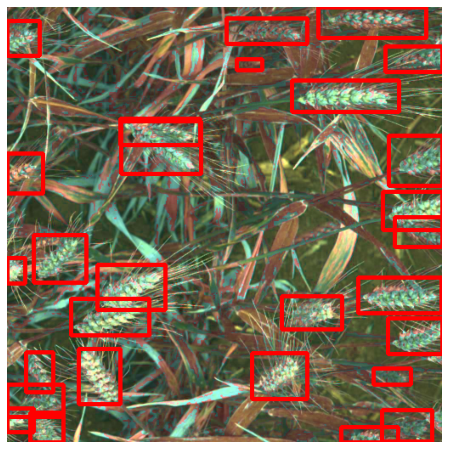

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

In [ ]:
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

In [ ]:
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:

model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth',map_location=torch.device('cpu')))
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 1


In [ ]:
train_hist = Averager()
t = 1
valid_pred_min = 0.65 
for epoch in range(num_epochs):
    train_hist.reset()
    
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss = losses.item()

        train_hist.send(train_loss)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if t % 50 == 0:
            print(f"Iteration #{t} loss: {train_loss}")

        t += 1
    
    
    model.eval()
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    for images, targets, image_ids in valid_data_loader:       
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images)
            
        
        
        
        for i, image in enumerate(images):
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
            gt_boxes = targets[i]['boxes'].cpu().numpy()
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = boxes[preds_sorted_idx]
            image_precision = calculate_image_precision(preds_sorted,
                                                        gt_boxes,
                                                        thresholds=iou_thresholds,
                                                        form='coco')
            validation_image_precisions.append(image_precision)

    valid_prec = np.mean(validation_image_precisions)
    print("Validation IOU: {0:.4f}".format(valid_prec))
              
       
    
    #print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
    ))
        
    ## TODO: save the model if validation precision has decreased
    if valid_prec >= valid_pred_min:
        print('Validation precision increased({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_pred_min,
            valid_prec))
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
        valid_pred_min = valid_prec



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #50 loss: 0.7455574870109558
Iteration #100 loss: 0.6142247319221497
Iteration #150 loss: 0.6047343015670776
Validation IOU: 0.5353
Epoch: 0 	Training Loss: 0.511259


# Evaluating Model 

In [ ]:
model.eval()
images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
outputs = model(images)


In [ ]:
detection_threshold = 0.5
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

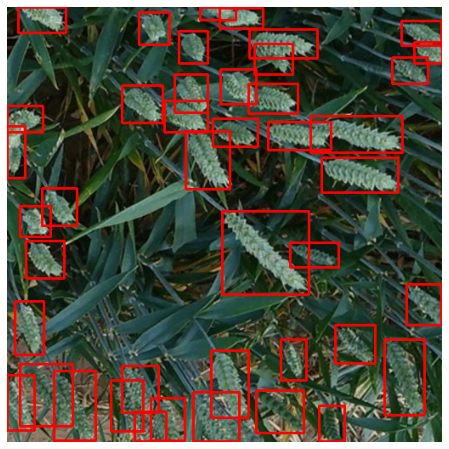

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)